## Exploratory Data Analysis of a Vehicles Dataset
### Report

Bronwyn Bowles-King

### 1. Introduction

This report explores a real dataset originally from *Ward's Automotive Yearbook* from 1985 about cars sold in the United States (US) (Schlimmer, 1985). By cleaning, preparing and correcting the dataset (section 2), and then visualising and summarising the main findings in interpertible ways, I hope to help readers understand some trends and characteristics of cars from this now historical period 40 years ago. The analysis will provide insights into some key features of these vehicles, including body styles, manufacturers, price levels, fuel efficiency, and engine sizes (section 3). All prices are discussed in US dollars, and the data should be seen in the context of the 1980s US automotive market (Leidy, 2024; Martin, 2019; Schlimmer, 1985). 

At the end of the analysis, I will answer the question as to which vehicle manufacturer likely has the most car models in the dataset (section 4). This question proved more difficult to answer than it seemed at first. Before calculating the number of models, I will first provide a definition of a car 'model' based on the features in the dataset and then infer from this the likely number of models by car brand.

---

### 2. Preparation steps: Data cleaning, preprocessing and inspection

##### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

##### Load and preview the data
Below, the plain text file with the automobile data provided is converted and saved to CSV as this format is easier to read and then a pandas dataframe is created for analysis in this notebook. Table 1 presents the first few rows of the raw data in the dataframe and then the dimensions (number of columns and rows) is displayed to get a sense of the typical entries, size and structure of the dataset. 

In [2]:
df_txt = pd.read_csv('automobile.txt', delimiter=',')

df_txt.to_csv('automobile.csv', index=False)

df_csv = pd.read_csv('automobile.csv')

display(HTML("<h4>Table 1: Vehicles raw dataset<h4>"))
display(HTML(df_csv.head(5).to_html()))

display(HTML(f'Dataframe dimensions: {df_csv.shape}'))

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


#### 2.1 Remove unnecessary columns

Columns that are not needed for this analysis are dropped below, namely, 'normalized-losses' and 'symboling'. The program then checks for duplicates, but none were found. 

In [3]:
automobiles_df = df_csv.drop(['normalized-losses', 'symboling'], axis=1)

duplicates = automobiles_df.duplicated().sum()
display(HTML(f'Duplicate rows found: {duplicates}.'))

#### 2.2 Handle missing values

Missing or problematic entries are detected, including the '?' character that appears several times in the data, and these rows are then removed. The size of the new, cleaned dataframe is displayed. We now have 193 entries to perform an analysis on.

In [4]:
automobiles_df.replace(['?', ''], np.nan, inplace=True)
df_cleaned = automobiles_df.dropna()
display(HTML(f'Cleaned dataframe dimensions: {df_cleaned.shape}'))

#### 2.3 Data conversion 

Columns with numerical data are identified and changed to integers as necessary to ensure the analysis can continue without errors.

In [5]:
numeric_cols = [
    'wheel-base', 'length', 'width', 'height', 'curb-weight', 
    'engine-size', 'bore', 'stroke', 'compression-ratio', 
    'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'
]

df_cleaned = automobiles_df.copy()  

for col in numeric_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
# Convert columns with whole numbers to integers
    if col in df_cleaned.columns:
        if pd.api.types.is_float_dtype(df_cleaned[col]):
            # Only convert to integers if all values are whole numbers
            if df_cleaned[col].dropna().apply(float.is_integer).all():
                df_cleaned[col] = df_cleaned[col].astype('Int64')

grouped_columns = (
    df_cleaned.columns.to_series()
    .groupby(df_cleaned.dtypes.astype(str))
    .groups
)
grouped_columns_dict = {str(k): list(v) for k, v in grouped_columns.items()}

output_lines = []
for dtype, cols in grouped_columns_dict.items():
    cols_str = '; '.join(cols)
    output_lines.append(f"{dtype}: {cols_str}")

output_text = '\n'.join(output_lines)
html_output = output_text.replace('\n', '<br>') # <br> is html line break
display(HTML(html_output))

#### 2.4 Data correction

Finally, the car brand names are updated and corrected below as they will appear often in the figures and tables to follow. The first few rows are then displayed to check if the corrections were successful. 

In [6]:
def car_makes(name):
    # Function to correct vehicle names
    if pd.isna(name):
        return name
    name_lower = name.lower().strip()
    return corrections.get(name_lower, name_lower.title())

corrections = {
    'bmw': 'BMW',
    'mercury': 'Mercury',
    'mercedes-benz': 'Mercedes-Benz',
    'alfa-romero': 'Alfa Romeo',
    'volkswagen': 'VW',
    'peugot': 'Peugeot',
    'subaru': 'Subaru',
    'volvo': 'Volvo',
    'toyota': 'Toyota',
    'saab': 'Saab',
    'porsche': 'Porsche',
    'plymouth': 'Plymouth',
    'nissan': 'Nissan',
    'mitsubishi': 'Mitsubishi',
    'mazda': 'Mazda',
    'jaguar': 'Jaguar',
    'isuzu': 'Isuzu',
    'honda': 'Honda',
    'dodge': 'Dodge',
    'chevrolet': 'Chevrolet',
    'audi': 'Audi'
}

df_cleaned['make'] = df_cleaned['make'].apply(car_makes)

display(HTML("<h4>Table 2: Cleaned and corrected dataframe<h4>"))
display(HTML(df_cleaned.head().to_html()))

,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,Alfa Romeo,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,Alfa Romeo,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,Alfa Romeo,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,Audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,Audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


### 3. Data analysis

#### 3.1 Comparing vehicle body types by manufacturer

Table 3 below shows the number of cars with each kind of body style represented in the cleaned dataset. There are 92 sedans, 63 hatchbacks, and 14 convertibles in the dataset. In this analysis, 'convertibles' refers to both hard (8) and soft top (6) types together. 

The dataset also contains 24 station wagon-style cars, but this type of vehicle has greatly fallen in popularity in recent years in countries such as South Africa and the US (Schmidt, 2025). Removing station wagons from the dataset below will allow for a more focused analysis on vehicle types that most people who can afford a car currently will be driving. This is a suitable approach because the analysis will become quite long if we try to consider all individual body types and, although the data is historical, we are still interested in it from our current perspective.

In [7]:
body_style_counts = df_cleaned['body-style'].value_counts().to_frame('count')
body_style_counts.index.name = 'body-style'

display(HTML("<h4>Table 3: Vehicle body styles<h4>"))
display(HTML(body_style_counts.to_html()))

df_cleaned = df_cleaned[df_cleaned['body-style'].str.lower() != 'wagon']

,count
body-style,
sedan,96
hatchback,70
wagon,25
hardtop,8
convertible,6


I will now generate a list of all manufacturers or brands in the dataset with the percentage they represent. Then, in the rest of this section, I will look at which manufacturers dominate each of the three vehicle body styles, and then at the prices of these vehicles. 

In [8]:
counts = df_cleaned['make'].value_counts()
percentages = df_cleaned['make'].value_counts(normalize=True).mul(100).round(2)

summary_df = pd.concat([counts, percentages], axis=1)
summary_df.columns = ['Count', 'Percentage (%)']

display(HTML("<h4>Table 4: Number and percentage of vehicles by manufacturer<h4>"))
display(HTML(summary_df.to_html()))

,Count,Percentage (%)
make,,
Toyota,28,15.56
Mazda,17,9.44
Nissan,15,8.33
Mitsubishi,13,7.22
Honda,12,6.67
VW,11,6.11
Subaru,8,4.44
Volvo,8,4.44
Dodge,8,4.44


Below, Figure 1 to 3 show the vehicles on bar graphs by manufacturer for hatchbacks, sedans and convertibles (both hard and soft top types are included).

#### 3.1.1 Body types and manufacturer: Hatchbacks

**Findings:** Most hatchback cars in this dataset are from Toyota (14), followed by Mitsubishi (9), and Honda (7). This is interesting as these manufacturers are no longer as well known for their hatchback vehicles in their newest models any more, at least in South Africa. 

There is also supposed to be one hatchback by Isuzu. This seemed problematic at first, as Isuzu does not make hatchback cars currently. However, back in the 1980s, Isuzu did make two hatchbacks. They are called, among other names depending on the country, the Impulse and the I-Mark. Initially, I wanted to drop this car from the dataframe as I thought it was an error, but some research showed that Isuzu was making hatchbacks around the time this dataset is from (Martin, 2019).

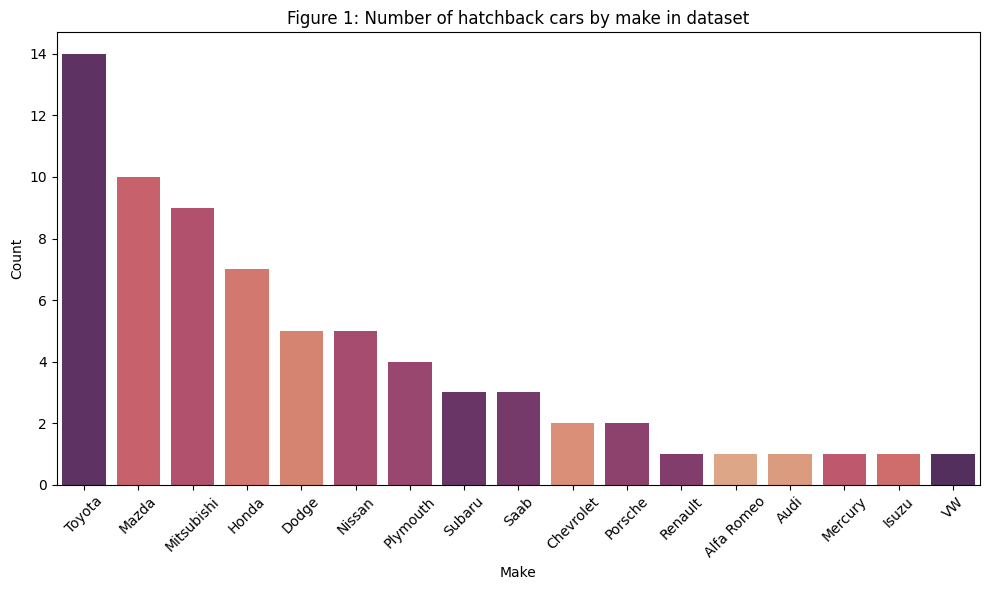

In [9]:
hatchback_cars = df_cleaned[df_cleaned['body-style'] == 'hatchback']

plt.figure(figsize=(10,6))
sns.countplot(
    data=hatchback_cars,
    x='make',
    hue='make',  
    order=hatchback_cars['make'].value_counts().index,
    palette='flare',
    legend=False  
)
plt.title('Figure 1: Number of hatchback cars by make in dataset')
plt.xlabel('Make')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 3.1.2 Body types and manufacturer: Sedans

**Findings:** Like the hatchbacks, most sedans in this dataset are also from Toyota (9), followed by VW and Nissan, with eight cars each, as shown in Figure 2. There are also many more sedans in this dataset than any other type of car. 

This is likely because sedans were very popular when this data was gathered in the mid-1980s, especially as family cars. Since then, sport utility vehicles (SUVs), crossovers and hatchbacks have tended to overtake them in South Africa and other countries (TopAuto, 2021). 

However, these cars are still seen on South African roads, such as BMW 3 series and VW Jetta sedans, and they are still in reasonable demand, regardless of the age of the car. They also represent the largest group by body style in this dataset. Thus, they are kept in the dataset going forward.

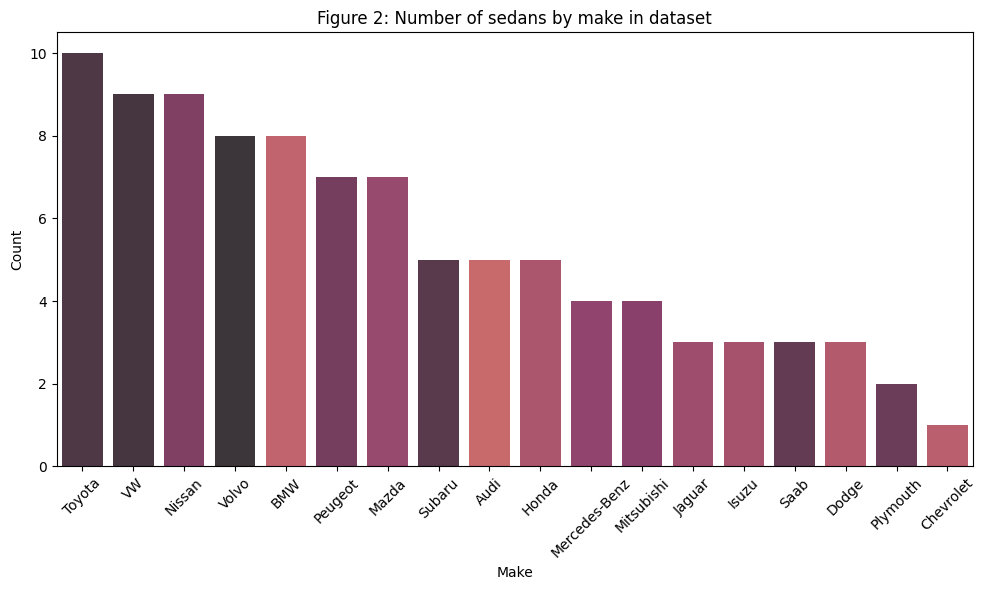

In [10]:
sedans = df_cleaned[df_cleaned['body-style'] == 'sedan']

plt.figure(figsize=(10,6))
sns.countplot(
    data=sedans,
    x='make',
    hue='make',  
    order=sedans['make'].value_counts().index,
    palette='flare_d',
    legend=False  
)
plt.title('Figure 2: Number of sedans by make in dataset')
plt.xlabel('Make')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 3.1.3 Body types and manufacturer: Convertibles

**Findings:** Again we find that most convertible cars are from Toyota (4) and thus this manufacturer dominates the cleaned dataset, with 28 (16.57%) vehicles in total (Table 4). Toyota is followed by Mercedes-Benz and Porsche with three convertible vehicles each. As more expensive, sporty cars, convertibles are less common, and thus there are only 14 examples from six manufacturers in this dataset (Figure 3). 

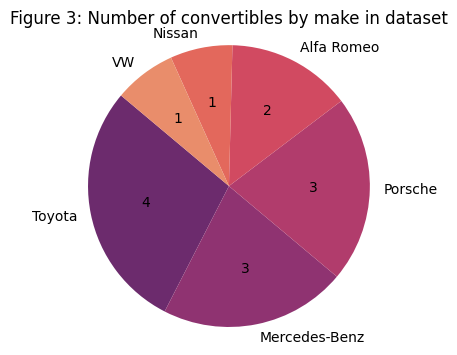

In [11]:
all_convertibles = df_cleaned[df_cleaned['body-style'].isin(['hardtop', 'convertible'])]
make_counts = all_convertibles['make'].value_counts()

colors = sns.color_palette('flare_r', n_colors=len(make_counts))

def make_percent(values):
    # Function to convert count to percentage before plotting pie chart
    def plot_autopct(pct):
        # Sub-function to return autopct, the matplotlib parameter to lable pie charts
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val}'
    return plot_autopct

plt.figure(figsize=(4,4))
plt.pie(
    make_counts,
    labels=make_counts.index,
    colors=colors,
    autopct=make_percent(make_counts),  # make_percent and autopct applied
    startangle=140
)
plt.title('Figure 3: Number of convertibles by make in dataset')
plt.axis('equal')
plt.show()


#### 3.2 Compare minimum, maximum and median price by car body type

Most people have a preferred vehicle body style and car brands they like. So, it is helpful to know the median price they can expect to pay based on their preferences. The minimum, maximum and median price are useful datapoints in that they are the actual lowest, highest and middle price that someone would pay.

Knowing the expected range for the bottomline is a good way to understand whether and to what extent a vehicle type and brand is affordable. This data is shown on the next graph below for body style specifically (Figure 4). 

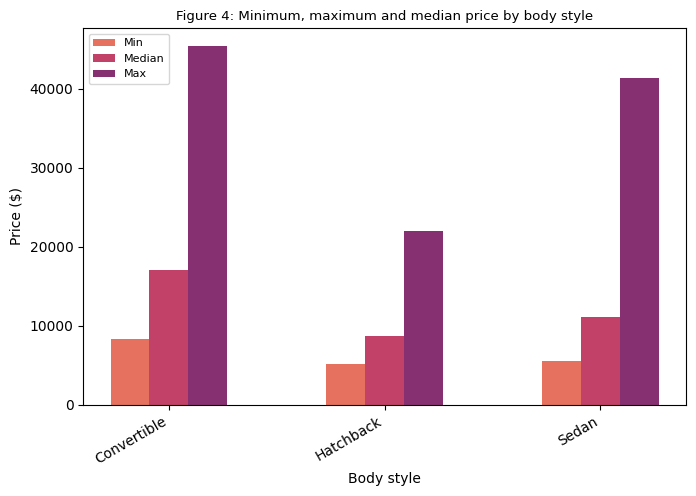

In [12]:
df_body_style = df_cleaned.copy()
df_body_style['body-style'] = df_body_style['body-style'].str.strip()
df_body_style['body_style_grouped'] = df_body_style['body-style'].replace(
    {'hardtop': 'convertible', 'convertible': 'convertible'}
)
df_body_style['body_style_grouped'] = df_body_style['body_style_grouped'].str.capitalize()

agg_body = df_body_style.groupby('body_style_grouped')['price'].agg(['min', 'median', 'max']).reset_index()

n_bars = len(agg_body)
palette = sns.color_palette("flare", n_colors=3)
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(n_bars)
width = 0.18
plt.rcParams.update({'font.size': 8})

bars_min = ax.bar(x - width, agg_body['min'], width, label='Min', color=palette[0])
bars_med = ax.bar(x, agg_body['median'], width, label='Median', color=palette[1])
bars_max = ax.bar(x + width, agg_body['max'], width, label='Max', color=palette[2])

ax.set_xticks(x)
ax.set_xticklabels(agg_body['body_style_grouped'], rotation=30, ha='right')
ax.set_xlabel('Body style')
ax.set_ylabel('Price ($)')
ax.set_title('Figure 4: Minimum, maximum and median price by body style')
ax.legend()
plt.tight_layout()
plt.show()

**Findings:** A person wanting the most affordable car is able to see from the graph above that a hatchback is a good choice, as the prices (1980s) start at about \$5 100. However, one sedan is only slightly more expensive at around \$5 500. This gives them some choices in terms of car size on a small budget under \$10 000. 

Those with a medium-sized budget up to \$20 000 also have room to look at all vehicle body types and consider the median price for each one: around \$8 200 for hatchbacks, \$11 600 for sedans, and \$17 000 convertibles, or perhaps one slightly higher or lower than this.  

Someone with a large budget, generally over \$20 000, may consider sedans and convertibles up to \$45 400, according to their needs, although they would be able to buy the most expensive hatchback at less than half this price (around \$22 000) if preferred. 
 
#### 3.3 Compare minimum, maximum and median price by manufacturer

The second two graphs show key datapoints by manufacturer, but these are split into more affordable (Figure 5) and more expensive cars (Figure 6) as fitting them on one figure was not possible. The graphs are sorted first by manufacturer price range overall and then by median price. This data would help someone decide which manufacturers have cars that are affordable for them. There is a range of 21 car brands, which hopefully includes at least two or three options that meet their preferences and budget.

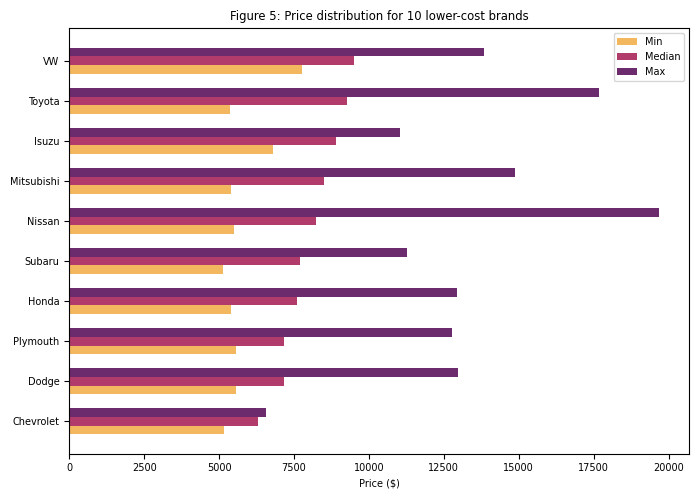

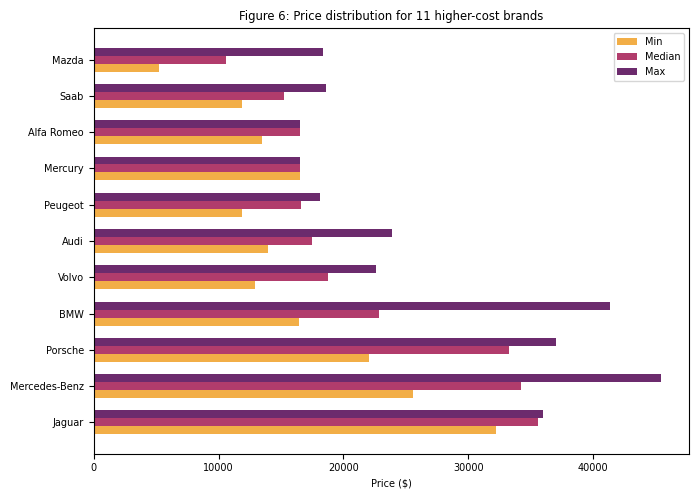

In [13]:
df_make = df_cleaned.copy()
df_make['make'] = df_make['make'].str.strip()

agg_make = df_make.groupby('make')['price'].agg(['min', 'median', 'max']).reset_index()
agg_make = agg_make.sort_values('median', ascending=True).reset_index(drop=True)

lowest_10 = agg_make.sort_values('median').head(10)

plt.figure(figsize=(7,5))
y = np.arange(len(lowest_10))
width = 0.22
plt.rcParams.update({'font.size': 7})

plt.barh(y - width, lowest_10['min'], width, label='Min', color="#F2B75F")
plt.barh(y, lowest_10['median'], width, label='Median', color="#b13c6c")
plt.barh(y + width, lowest_10['max'], width, label='Max', color="#6c2b6d")

plt.yticks(y, lowest_10['make'])
plt.xlabel('Price ($)')
plt.title('Figure 5: Price distribution for 10 lower-cost brands')
plt.legend()
plt.tight_layout()
plt.show()

highest_11 = agg_make.sort_values('median', ascending=False).head(11)

plt.figure(figsize=(7,5))
y = np.arange(len(highest_11))
width = 0.22
plt.rcParams.update({'font.size': 7})

plt.barh(y - width, highest_11['min'], width, label='Min', color="#F2AE47")
plt.barh(y, highest_11['median'], width, label='Median', color="#b13c6c")
plt.barh(y + width, highest_11['max'], width, label='Max', color='#6c2b6d')

plt.yticks(y, highest_11['make'])
plt.xlabel('Price ($)')
plt.title('Figure 6: Price distribution for 11 higher-cost brands')
plt.legend()
plt.tight_layout()
plt.show()

**Findings:** A person wanting the most affordable option under $10 000 from this dataset and in the 1980s would be able to see that Chevrolet, Dodge and Plymouth have cars within the lowest budget range (Figure 5). This is likely because these cars are American and this dataset is also from the US. Locally made vehicles can be more affordable. This gives a person on a smaller budget who prefers American cars a few options to consider. 

Many Japanese brands - Nissan, Honda and Mitsubishi to name a few - are also on the more affordable side for entry-level cars and their price range is lower overall, with a median generally under $10 000. Those on a smaller budget may be able to consider their entry-level options, as well as those of VW (Figure 6). 

Someone who likes Japanese cars and has a medium-sized budget under $20 000 will have many options to consider here. They can consider top-of-the-range cars from the Japanese or American brands previously mentioned. We can see here that Japanese car-makers were keeping their prices relatively low in the 1980s, which is often still true today, but likely their prices were higher than the US brands mentioned above due to import taxes. 

Furthermore, VW, Isuzu, Toyota, Nissan and Saab offer similar cars for people on a mid-range budget, although some may not be able to afford the most expensive among these brands. However, if they stretch their budget, they might be able to afford Toyota's or Nissan's upper-end vehicles or an entry-level Alpha Romeo, Volvo, BMW or Peugeot (Figure 6). 

Someone with a much larger budget over $20 000 may, of course, consider any brand they wish, but if they want the most luxurious vehicle, they can choose from the more expensive Audi, Volvo, BMW, Porsche, Mercedes or Jaguar cars. We can immediately see why these brands are more expensive overall, including for their lowest-priced cars. Audi, BMW, Mercedes-Benz and Porsche are German cars. Volvo is Swedish and Jaguar is from the UK. European cars do tend to be more expensive and import taxes will add to this. 

One exception in this dataset is VW, as a European brand which used to make several budget cars, although this is mostly no longer the case (Mokoena, 2025). The VW vehicles are all under $15 000 in this dataset, making even their best cars affordable for those on an mid-range budget in the 1980s. 

#### 3.4 Compare average fuel efficiency by manufacturer

In this section, the overall miles per gallon are compared across car brands to see which ones are most fuel efficient.

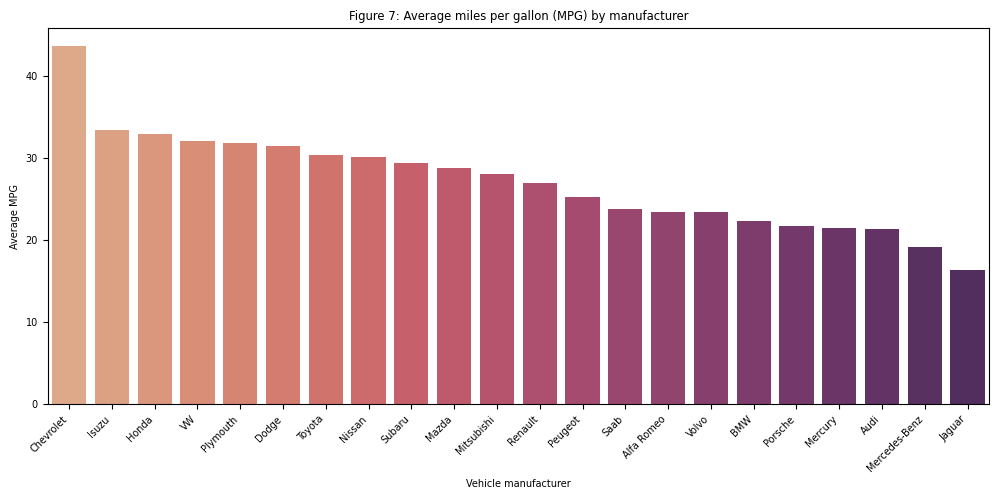

In [14]:
df_cleaned['average-mpg'] = df_cleaned[['city-mpg', 'highway-mpg']].mean(axis=1)
ave_mpg = round(df_cleaned.groupby('make')['average-mpg'].mean().reset_index(), 2)
ave_mpg_sorted = ave_mpg.sort_values(by='average-mpg', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(
    data=ave_mpg_sorted,
    x='make',
    hue='make',
    y='average-mpg',
    palette='flare',
    legend=False
)
plt.ylabel('Average MPG')
plt.xlabel('Vehicle manufacturer')
plt.title('Figure 7: Average miles per gallon (MPG) by manufacturer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Findings:** We can see from Figure 7 above that, almost without exception, a cheaper car uses less fuel and a more expensive car uses more fuel, so that fuel consumption and price are nearly perfectly aligned. 

The Chevrolet stands out as the clear winner by a considerable margin of around 10 MPG above its closet rival in fuel efficiency, Honda. One exception is the single Mercury vehicle in the dataset, which is in the mid-price range under $20 000, but has the third-highest fuel consumption. Such high fuel consumption rates shown on the graph are likely due to a larger engine capacity, bigger car size, and a shape that is not aerodynamic (Ford Motor Company, 2024).

#### 3.5 Compare average engine capacity by manufacturer

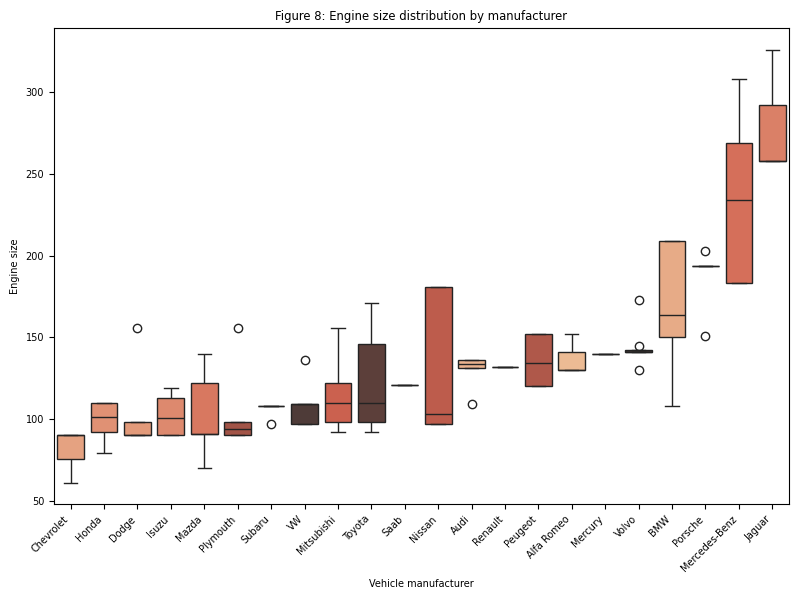

In [15]:
mean_eng = df_cleaned.groupby('make')['engine-size'].mean().reset_index()
mean_eng_sorted = mean_eng.sort_values(by='engine-size', ascending=True)
order = df_cleaned.groupby('make')['engine-size'].mean().sort_values().index

plt.figure(figsize=(8,6))
sns.boxplot(
    data=df_cleaned,
    x='make',
    hue='make',
    y='engine-size',
    order=order,             
    palette= 'OrRd_d'
    )

plt.ylabel('Engine size')
plt.xlabel('Vehicle manufacturer')
plt.title('Figure 8: Engine size distribution by manufacturer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Findings:** As expected, budget cars have a small engine size and expensive cars have larger engines overall in Figure 8. Fuel consumption, price and engine size are nearly perfectly aligned across the manufacturers. Engine size is directly related to how much fuel will be needed to drive a car the same distance and to its price in this dataset.  

The Mercury is again a bit of an exception, with its larger engine size in spite of its mid-range cost. This makes it unsuitable for people who want a small, fuel-efficient car. The cost of fuel for the Mercury's engine would also be the same or higher than a luxury sedan or sportscar, such as an Audi or Porsche (Figure 7). The Mercury thus has poor fuel efficiency compared to other cars of the same price.

This data will help someone who is on a budget, who does a lot of driving, and/or is environmentally conscious to make an informed choice when considering car brands against each other. Most likely, they will be interested in the Chevrolet, Honda, Plymouth and Dodgde cars, while those with a bigger budget who are still environmentally conscious can consider the Subaru, VW, Mazda, Isuzu, Mitsubishi and Toyota cars. People with more money, however, do not have to restrict themselves to any brand or engine size, which is very sad for our planet.  

#### 4. Which vehicle manufacturer has the most models in the dataset?

Car models are not given in the dataset. For example, 'Toyota' is one of the car brands, but not whether a particular record is for a Camry, Corolla or another model. The definition of a car model is also open to debate here. The BMW 3 series comes in sedans, convertibles and, once upon a time, station wagons. These are all different models, but in the same 'series'. Different car models can have similar specs and even the exact same engine or they can be the same model with slightly or widely different specs (Hearst Autos Research, n.d.). Additionally, every manufacturer has freedom to customise and name its car models in their own way. 

Having more data would make it easier to distinguish between car models. Not having it makes the question above seem nearly impossible to answer. How does one define a 'model', at least for the purposes of this dataset? 

I have done some research by asking people who know more about cars and decided on the definition of a car 'model' for this report. This is having the same:

* Make
* Body style
* Engine type 
* Fuel type 
* Drive wheels 
* Horsepower
* Number of cylinders (Hearst Autos Research, n.d.)

A car can be of the same model, but have a different price, engine size, aspiration, number of doors, etc., for the purposes of this report. 

Based on the features of a model listed above, the answer is calculated and printed below and then a word cloud in Figure 9 displays the results for all the car brands. 

In [16]:
model_cols = ['make', 'body-style', 'engine-type', 'drive-wheels', 'num-of-cylinders', 'fuel-type', 'horsepower']

unique_models = df_cleaned.drop_duplicates(subset=model_cols).groupby('make').size()
most_models = unique_models.idxmax()
count_models = unique_models.max()
display(HTML(
    f'<h4>{most_models} most likely has the most car models in this dataset, with about {count_models} different models, based on the defined features for this dataset.<h4>'
))

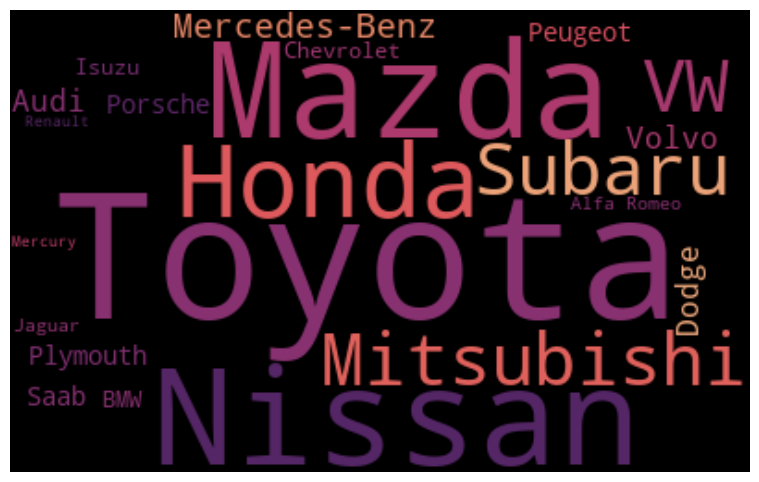

In [17]:
display(HTML("<h4>Figure 9: Word cloud by number of models and manufacturer<h4>"))

model_dict = unique_models.to_dict()
wordcloud = WordCloud(
    width=400, height=250, background_color='black', colormap='flare'
).generate_from_frequencies(model_dict)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

My approach likely has not been sufficient to sort and count all individual car 'models' accurately, and this is open to debate, as stated before. Regardless of how a model is defined by adding or removing features, nevertheless, Toyota repeatedly comes out as having the most models. By the definition applied, there are 17 different models out of the 28 individual Toyota entries in the dataset. This seems a reasonable conclusion based on the overall analysis of the 1985 automobiles dataset.

### 5. Conclusion

This analysis of a 1985 vehicles dataset has highlighted some trends in car body styles, manufacturers, prices, fuel efficiency, and engine sizes for hatchbacks, sedans and convertible cars. Toyota emerged as the most prominent brand, offering a wide variety of models, while several US brands offer competitive prices and fuel-efficient cars. The findings show a clear relationship between price, fuel consumption, and engine size so that as one increases, the other factors also generally increase. 

This type of data helps guide potential buyers in a market where there are many choices. While some limitations exist due to the dataset’s age and scope, the insights gained provide a perspective on the automotive market from 40 years ago.

**References**

EPA. (2025). Exploratory Data Analysis. https://www.epa.gov/caddis/exploratory-data-analysis

Ford Motor Company. (2024). A Short History of the Mercury Brand. https://corporate.ford.com/articles/history/history-of-the-mercury-brand.html

Hearst Autos Research. (n.d.). What Is the Difference Between Make and Model? *Car and Driver*. https://www.caranddriver.com/research/a31875496/difference-between-make-and-model

HyperionDev. (2025a). Data Cleaning and Preprocessing. Course materials. Private repository, GitHub.

HyperionDev. (2025b). Exploratory Data Analysis. Course materials. Private repository, GitHub.

Jupyter Team. (2015). Apply Custom CSS. https://jupyter-notebook.readthedocs.io/en/stable/custom_css.html 

Leidy, L. (2024). What an Average Car Cost in the Year You Were Born. Yahoo Finance. https://finance.yahoo.com/news/average-car-cost-were-born-130001087.html

Martin, M. (2019). Junkyard Gem: 1986 Isuzu I-Mark Hatchback. AutoBlog. https://www.autoblog.com/news/junkyard-gem-1986-isuzu-i-mark-hatchback 

matplotlib. (2012). Horizontal bar chart. https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html

Mokoena, T. (2025). Toyota vs. Volkswagen: Maintenance Cost Comparison. iMoto News. https://imotonews.co.za/2025/04/30/toyota-vs-volkswagen-maintenance-cost-comparison

Mueller, A. (2020). wordcloud.WordCloud. https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud-wordcloud

Mueller, A. (2020). Using frequency. https://amueller.github.io/word_cloud/auto_examples/frequency.html

Numpy. (2025). numpy.arrange. https://numpy.org/doc/stable/reference/generated/numpy.arange.html

pandas. (2025). astype. https://pandas.pydata.org/docs/user_guide/basics.html#astype

pandas. (2025). Categorical data. https://pandas.pydata.org/docs/user_guide/categorical.html

pandas. (2025). pandas.DataFrame.drop_duplicates. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html

pandas. (2025). pandas.DataFrame.groupby. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

pandas. (2025). pandas.DataFrame.mul. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mul.html#pandas-dataframe-mul

pandas. (2025). pandas.Index.to_series. https://pandas.pydata.org/docs/reference/api/pandas.Index.to_series.html

Schlimmer, J. (1985). Automobile [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5B01C

Schmidt, J. (2025). The locally forgotten wagon. *Top Gear SA*. https://www.topgear.co.za/big-read/the-locally-forgotten-wagon

StackOverflow. (2020). Display HTML in Python Notebook. https://stackoverflow.com/questions/64573529/display-html-in-python-notebook

StackOverflow. (2010). How to change the font size on a matplotlib plot. https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

TopAuto. (2021). The slow death of the Sedan in South Africa. https://topauto.co.za/news/31552/the-slow-death-of-the-sedan-in-south-africa

In [18]:
display(HTML("""
<style>
table.dataframe th {
    background-color: #6c2b6d;
    color: white;
    font-size: 11px;
}
table.dataframe td {
    font-size: 10px;
    border: 1px solid #0000;
}
table.dataframe tr:hover {
    background-color: #ccc;
}
</style>
"""))